In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from ODE import ConvODEF, ContinuousNeuralMNISTClassifier
from MNIST_Trainer import train, test
from solvers import ode_solve_euler
from neuralode import NeuralODE


use_cuda = torch.cuda.is_available()

In [2]:
func = ConvODEF(64)
ode = NeuralODE(func, ode_solve_euler)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [3]:
#preparing the data of MNIST dataset

import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)



In [4]:
print(test_loader)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

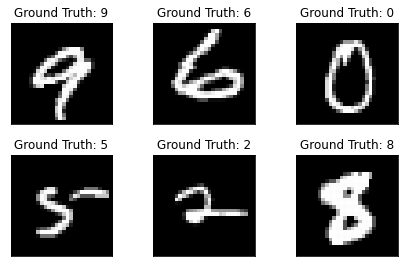

In [5]:
#printing the ground truth
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [6]:
optimizer = torch.optim.Adam(model.parameters())

In [7]:
#Training the model
n_epochs = 1
test(model, test_loader)
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch, model, train_loader, optimizer)
    test(model, test_loader)

Testing...



Test Accuracy: 9.800%
Training Epoch 1...



Train loss: 0.15933
Testing...



Test Accuracy: 97.630%


<Figure size 648x360 with 0 Axes>

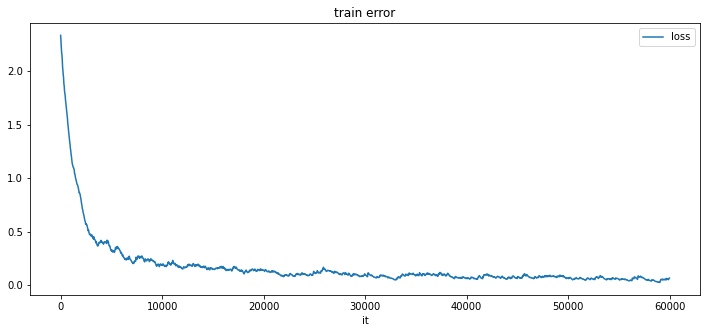

In [12]:
#Plotting the loss function
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["it"] = history.index * batch_size
history["loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="it", y="loss", figsize=(12, 5), title="train error")

In [9]:
with torch.no_grad():
    model.eval()
    if use_cuda: data = example_data.cuda()
    output = model(data)

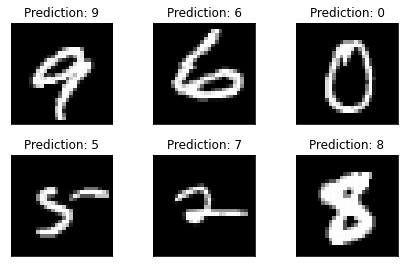

In [10]:
#Printing the ground truth against Prediction
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])